# all-MiniLM-L6-v2

In [26]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
# Expand the same realistic receipt-style generation to all categories
import pandas as pd
import random
from datetime import datetime, timedelta

# Enhanced receipt-like entries for all categories
receipt_expanded = {
    "food": [
        "GV CHNK CHKN", "GV PARM 160Z", "SC TWIST UP", "FOLGERS", "EGGS", "GOGO SQUEEZ", "CAMPBELLS",
        "GG RTE RICE", "QUAKER CHEWY", "OLD EL PASO", "GG CONDIMENT", "SPARKLNG ICE", "SO DELICIOUS",
        "PROGRESSO", "NESTLE", "PB ORG CRMY", "FRZ PZA PEPP", "BTR MLK BIS", "12 PK COKE", "OREO MINI"
    ],
    "transportation": [
        "UBR RIDE CNTR", "LFT TO UNI", "GAS 10L", "SHELL 20L", "DLVRY FEE", "SRVCE FEE",
        "TOLL HWY 407", "PRESTO RELOAD", "PARK METER", "EV CHARGE", "CAR WASH", "GAS+CARWASH PKG",
        "GO TKT ZONE3", "BIKESHARE 30M", "UBR XL", "GAS STN", "SCOOT APP FEE", "VALT PARK", "TTC ONE WAY", "UBR TIP"
    ],
    "clothing": [
        "TRVL SOCKS", "H&M MNS SHRT", "JKT PUFFER BLK", "WOMNS CREW S", "BASIC TEE", "CHMPN HOODIE",
        "KDS SNOW CAP", "LADY LGGN", "MNS PANTS L", "ZRA DNM JNS", "SHOE INSOLE", "WRK BOOTS",
        "ATH SHORTS", "TANK TOP", "KNIT CAP", "DRY FIT LS", "UNDWR 3PK", "GYM BAG", "GLVS TOUCH", "HOOD ZIP"
    ],
    "home/appliances": [
        "12 CT NITRIL", "CABLE POUCH", "TRVL PILLOW", "AIR FRESHNR", "LED BULB", "PLUG CORD 2M",
        "TP 24 ROLL", "FEBREZE ORIG", "DISH SOAP", "TIDE PODS", "MOP REFILL", "MICROWV CVR",
        "FAN TOWER", "HEATER MINI", "IKEA SHELF", "PAPER TOWELS", "BROOM SET", "TOOLKIT MINI", "BASKET STOR", "RUG MAT"
    ],
    "alcohol/entertainment": [
        "BUD 6PK", "WINE MERLOT", "MVIE TCKT", "CLUB COVR", "KTCHEN PRTY", "VID GAME DLC", "BREW IPA",
        "TEQ SHOT", "BAR SNACK", "LIVE BAND", "BEER TALLCAN", "GNRL ADMSN", "BOWLNG NT", "ARCADE CRD",
        "KTV RM RENT", "THEATER POP", "PUB NIGHT", "2FOR1 MVIE", "CIDER", "ESCAPE FEE"
    ],
    "other": [
        "GIFT CARD $25", "BAG CHRG", "Target Circle10%", "AMOUNT", "SRCHRG", "PIN PKG", "USB CBL",
        "NOTEBOOK", "STKY NTS", "CALENDAR 2024", "PEN GEL 4PK", "MASK 10CT", "PHOTO PRINT",
        "WALMART BAG", "APPLECARE", "BATTERY AAA", "ENGRAVED MUG", "DONATION", "CHARITY ROUNDUP", "EXTRA WARRANTY"
    ]
}

# Class distribution
class_distribution = {
    "food": 150,
    "transportation": 100,
    "clothing": 80,
    "home/appliances": 90,
    "alcohol/entertainment": 60,
    "other": 70
}

rows = []
start_date = datetime.strptime("2022-01-01", "%Y-%m-%d")

for category, count in class_distribution.items():
    for _ in range(count):
        item = random.choice(receipt_expanded[category])
        # add noise
        if random.random() < 0.2:
            item += f" {random.choice(['XL', 'MD', 'SM', '2PK', '16OZ', '500ML'])}"
        if random.random() < 0.15:
            item = item.lower()
        if random.random() < 0.07:
            item = item.replace(" ", "")  # simulate receipt joining
        price = round(random.uniform(0.5, 45.0), 2)
        date_offset = random.randint(0, 700)
        date = (start_date + timedelta(days=date_offset)).strftime("%Y-%m-%d")
        rows.append([date, item, price, category])

# Save to CSV
df_expanded = pd.DataFrame(rows, columns=["date", "item", "price", "class"])
expanded_path = "dummy_receipts.csv"
df_expanded.to_csv(expanded_path, index=False)

expanded_path


'dummy_receipts.csv'

In [28]:
# Load and preprocess dataset
df = pd.read_csv("dummy_receipts.csv")
df = df[['item', 'class']].dropna()

# Fix inconsistent labels
category_map = {
    "applicances": "home/appliances",
    "home": "home/appliances",
    "transportation": "transport",
    "entertainment/alcohol": "alcohol/entertainment"
}
df["class"] = df["class"].str.lower().replace(category_map)

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["class"])

# Split data
# Drop duplicates to prevent data leakage (same item appearing in both train and val)
df_unique = df.drop_duplicates(subset=["item"])
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    df_unique["item"].tolist(),
    df_unique["label"].tolist(),
    test_size=0.2,
    stratify=df_unique["label"],
    random_state=42
)

# Load pretrained MiniLM
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [29]:
# Custom Dataset
class ReceiptDataset(Dataset):
    def __init__(self, texts, labels):
        self.embeddings = embedding_model.encode(texts, convert_to_tensor=True)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_loader = DataLoader(ReceiptDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(ReceiptDataset(X_val, y_val), batch_size=16)

# Define classifier model
class MiniLMClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, output_dim=6):
        super(MiniLMClassifier, self).__init__()
        self.name = f"MiniLM_FC{input_dim}-{hidden_dim}-{output_dim}"
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.classifier(x)

In [30]:
# Training and evaluation utilities
def get_model_name(name, learning_rate, epoch):
    return f"model_{name}_lr{learning_rate}_epoch{epoch}"

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(train_loader), correct / total

def get_accuracy(model, loader):
    correct, total = 0, 0
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def evaluate(model, loader, criterion):
    device = next(model.parameters()).device
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader), get_accuracy(model, loader)

def save_model(model, save_dir, learning_rate, epoch):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        model_name = get_model_name(model.name, learning_rate, epoch)
        model_path = os.path.join(save_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved: {model_path}")

def plot_results(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(valid_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(valid_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.show()

In [31]:
def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-4, device="cuda", save_dir="./checkpoints"):
    if device == "cuda" and not torch.cuda.is_available():
        print("CUDA is not available. Switching to CPU.")
        device = "cpu"
    print(f"Using device: {device}")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, valid_loader, criterion)

        train_losses.append(train_loss)
        valid_losses.append(val_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] → Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        save_model(model, save_dir, learning_rate, epoch+1)

    plot_results(train_losses, valid_losses, train_accuracies, valid_accuracies)

    return {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "train_accuracies": train_accuracies,
        "valid_accuracies": valid_accuracies
    }

Using device: cuda
Epoch [1/30] → Train Loss: 1.7850, Acc: 0.1905 | Val Loss: 1.7622, Acc: 0.3448
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.001_epoch1.pth
Epoch [2/30] → Train Loss: 1.7262, Acc: 0.5325 | Val Loss: 1.7155, Acc: 0.4655
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.001_epoch2.pth
Epoch [3/30] → Train Loss: 1.6536, Acc: 0.6840 | Val Loss: 1.6425, Acc: 0.6207
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.001_epoch3.pth
Epoch [4/30] → Train Loss: 1.5390, Acc: 0.7662 | Val Loss: 1.5502, Acc: 0.5862
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.001_epoch4.pth
Epoch [5/30] → Train Loss: 1.4082, Acc: 0.7922 | Val Loss: 1.4403, Acc: 0.6379
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.001_epoch5.pth
Epoch [6/30] → Train Loss: 1.2372, Acc: 0.8571 | Val Loss: 1.3193, Acc: 0.7069
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.001_epoch6.pth
Epoch [7/30] → Train Loss: 1.0815, Acc: 0.8528 | Val Loss: 1.1948, Acc: 0.6897
Mo

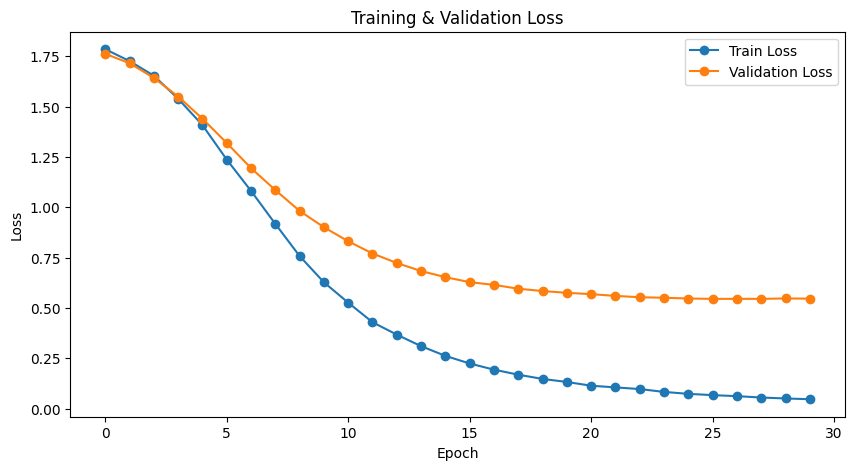

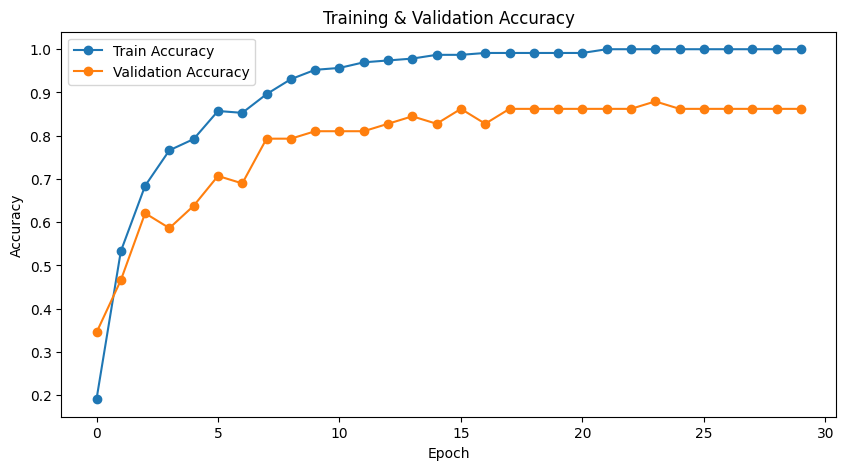

In [32]:
model = MiniLMClassifier(output_dim=len(label_encoder.classes_))
results = train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001)

In [33]:
import pandas as pd

# Load your dataset
df = pd.read_csv("receipts_data_final.csv")

# Clean up inconsistent labels
category_map = {
    "applicances": "home/appliances",
    "home": "home/appliances",
    "transportation": "transport",
    "entertainment/alcohol": "alcohol/entertainment"
}
df["class"] = df["class"].str.lower().replace(category_map)

# Print class distribution
class_counts = df["class"].value_counts()
print("Class Distribution:\n")
print(class_counts)


Class Distribution:

class
food                     239
home/appliances          101
other                     80
alcohol/entertainment      5
clothing                   5
transport                  4
Name: count, dtype: int64
